In [1]:
from PIL import Image, ImageDraw, ImageFont, ImageTk
from IPython.display import display
from camelup import camelup, config
from glob import glob
import random
import os
import sys

In [2]:
game = camelup.Game(3)

camel_dict = {
    "white": {"height":1, "space":3, "need_roll": True},
    "red": {"height": 2, "space": 3, "need_roll": True},
    "blue": {"height": 3, "space": 3, "need_roll": True},
    "green": {"height": 1, "space": 16, "need_roll": True},
    "yellow": {"height": 4, "space": 3, "need_roll": True},
}
game.camel_dict = camel_dict

tiles_dict = {
    1:{"tile_type":"block","owner":1}
}
game.tiles_dict = tiles_dict

In [3]:
img = Image.new('RGB', (500, 500), color = (236,192,81))
font = ImageFont.truetype("../fonts/arial.ttf", 9)

In [4]:
def create_board(img):
    board_info = dict()
    draw = ImageDraw.Draw(img)
    border = 5
    width = (img.size[0]-border*2)/5
    height = (img.size[1]-border*2)/5
    space = 1
    top_left_corner = (border,border)
    bottom_right_corner = (top_left_corner[0] + width, top_left_corner[1] + height)
    draw.rectangle([top_left_corner, bottom_right_corner], fill = (251,207,41), outline = (29,29,29))
    draw.text((top_left_corner[0]+2, top_left_corner[1]+2), str(space), font=font, fill=(0,0,0))
    board_info[space]=(top_left_corner,bottom_right_corner)
    space += 1
    for i in range(4):
        top_left_corner = (top_left_corner[0] + width, top_left_corner[1])
        bottom_right_corner = (top_left_corner[0] + width, top_left_corner[1] + height)
        draw.rectangle([top_left_corner, bottom_right_corner], fill = (251,207,41), outline = (29,29,29))
        draw.text((top_left_corner[0]+2, top_left_corner[1]+2), str(space), font=font, fill=(0,0,0))
        board_info[space]=(top_left_corner,bottom_right_corner)
        space +=1
    for i in range(4):
        top_left_corner = (top_left_corner[0], top_left_corner[1]+ height)
        bottom_right_corner = (top_left_corner[0] + width, top_left_corner[1] + height)
        draw.rectangle([top_left_corner, bottom_right_corner], fill = (251,207,41), outline = (29,29,29))
        draw.text((top_left_corner[0]+2, top_left_corner[1]+2), str(space), font=font, fill=(0,0,0))
        board_info[space]=(top_left_corner,bottom_right_corner)
        space +=1
    for i in range(4):
        top_left_corner = (top_left_corner[0] - width, top_left_corner[1])
        bottom_right_corner = (top_left_corner[0] + width, top_left_corner[1] + height)
        draw.rectangle([top_left_corner, bottom_right_corner], fill = (251,207,41), outline = (29,29,29))
        draw.text((top_left_corner[0]+2, top_left_corner[1]+2), str(space), font=font, fill=(0,0,0))
        board_info[space]=(top_left_corner,bottom_right_corner)
        space +=1
    for i in range(3):
        top_left_corner = (top_left_corner[0], top_left_corner[1]- height)
        bottom_right_corner = (top_left_corner[0] + width, top_left_corner[1] + height)
        draw.rectangle([top_left_corner, bottom_right_corner], fill = (251,207,41), outline = (29,29,29))
        draw.text((top_left_corner[0]+2, top_left_corner[1]+2), str(space), font=font, fill=(0,0,0))
        board_info[space]=(top_left_corner,bottom_right_corner)
        space +=1   
    draw.text((120, 340), 'To Be Rolled', font=font, fill=(0,0,0))

    bet_str = 'Bet Tiles (Colour - Value)'
    for key, val in game.bet_tiles.items():
        bet_str += f'\n{key} - {val[0]}'
    draw.text((120, 120), bet_str, font=font, fill=(0,0,0))   

    player_str = 'Player Items'
    for key, val in game.player_dict.items():
        player_str += f'\n{val["name"]} Coins: {val["coins"]} Bet Tiles: '
        for tile, bets in game.player_dict[key]['bet_tiles'].items():
            player_str += f'{tile[0]}('
            player_str += ', '.join(str(x) for x in bets)
            player_str += ') '
    draw.text((120, 220), player_str, font=font, fill=(0,0,0))

    game_str = f'Winner Bets: {len(game.winner_bets)}\nLoser Bets: {len(game.loser_bets)}'
    draw.text((300, 120), game_str, font=font, fill=(0,0,0))
    return board_info

In [5]:
def modulo_space(space):
    if space % 16 == 0:
        return 16
    else:
        return space % 16

In [6]:
def open_camel(file):
    camel = Image.open(file)
    transparency = Image.new('RGBA', camel.size, (0, 0, 0, 0))
    transparency.paste(camel, (0,0))
    per = 0.1
    wsize = int(transparency.size[0]*per)
    hsize = int(transparency.size[1]*per)
    return transparency.resize((wsize,hsize), Image.ANTIALIAS)
    

In [7]:
def place_camel_dict(img, game, board_info):
    counter = 0
    border = 5
    width = (img.size[0]-border*2)/5
    for camel, values in game.camel_dict.items():
        file = glob(f'../img/*{camel}*')[0]
        pic = open_camel(file)
        square = board_info[modulo_space(values['space'])]
        x = int(square[0][0] + width/2-(pic.size[0]/2))
        y = int(square[1][1] - pic.size[0] - ((values['height']-1)*14))
        img.paste(pic, (x,y), mask = pic)
        if values['need_roll']:
            x = 120 + counter*35 
            y = 350
            img.paste(pic, (x,y), mask = pic)
            counter +=1

In [10]:
def place_tiles(img,game,board_info):
    draw = ImageDraw.Draw(img)
    for space, val in game.tiles_dict.items():
        tile = board_info[space]
        top_left_corner = (tile[0][0]+10,tile[0][1]+10)
        bottom_right_corner = (tile[1][0]-10,tile[1][1]-10)
        draw.rectangle([top_left_corner, bottom_right_corner], fill = (255,225,255), outline = (29,29,29))
        draw.text((tile[0][0]+25, tile[0][1]+35), val['tile_type'], font=font, fill=(0,0,0))
    

In [11]:
board_info = create_board(img)
place_camel_dict(img,game,board_info)
place_tiles(img, game,board_info)

In [12]:
game.tiles_dict

{1: {'tile_type': 'block', 'owner': 1}}

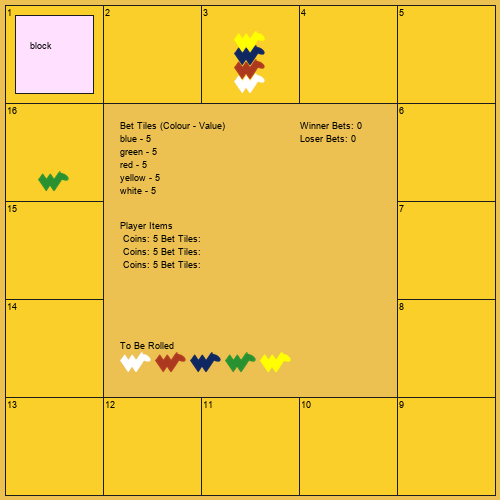

In [13]:
img

In [14]:
import tkinter as tk
from tkinter import ttk

In [15]:
def update():
    img = Image.new('RGB', (500, 500), color = (236,192,81))
    board_info = create_board(img)
    place_camel_dict(img,game,board_info)
    place_tiles(img,game,board_info)
    label.img = ImageTk.PhotoImage(img)
    label.config(image=label.img)
    combo.config(values=list(game.available_moves().keys()))
    player_turn_text.set(f"Turn: Player {game.player_dict[game.state]['name']}")

In [16]:
def play():
    print(combo.get())
    if combo.get() == 'Roll':
        need_roll = [key for key in game.camel_dict.keys() if game.camel_dict[key]["need_roll"]]
        camel = random.choice(need_roll)
        roll = random.randint(1, 3)
        output = game.play(game.available_moves()[combo.get()].replace("camel", f"'{camel}'").replace(', roll', f', {roll}'))
        turn_info.set(f'Camel: {camel} Rolled: {str(roll)}')
        if output == 'Done':
            game_end = 'Game Done'
            player_turn.grid_forget()
            combo.grid_forget()
            turn_enter.grid_forget()
            img = Image.new('RGB', (500, 500), color = (236,192,81))
            board_info = create_board(img)
            place_camel_dict(img,game,board_info)
            place_tiles(img,game,board_info)
            label.img = ImageTk.PhotoImage(img)
            label.config(image=label.img)
            global end
            end = tk.Label(mainframe, text=game_end)
            end.grid(column = 1, row=0, rowspan = 2)
            global restart
            restart = tk.Button(mainframe, text="Play Again", command=restart_game)
            restart.grid(column = 1, row=2)
            return
    else:
        game.play(game.available_moves()[combo.get()])
    update()

In [17]:
def destroy_start():
    for counter, name in enumerate(names):
        game.player_dict[counter+1]['name'] = name.get()
    update()
    mainframe.lift() 

In [18]:
def name_text_boxes(event):
    for name in names:
        name.destroy()
    for label in player_labels:
        label.destroy()
    game_enter.pack_forget()
    global game
    game = camelup.Game(int(num_players.get()))
    del names[:]
    del player_labels[:]
    for num in range(int(num_players.get())):
        player_labels.append(tk.Label(startframe, text=f'Player: {num+1}'))
        player_labels[-1].grid(row = num+1,column = 0)
        names.append(tk.Entry(startframe))
        names[-1].grid(row = num+1,column = 1)
    game_enter.grid(row = num + 2, column = 0, columnspan=1)

In [19]:
def restart_game():
    global game
    game = camelup.Game(2)
    startframe.lift()  
    end.grid_forget()
    restart.grid_forget()
    player_turn.grid(column = 1, row=0)
    combo.grid(column = 1, row = 1)
    turn_enter.grid(column=1, row=2)

In [20]:
root = tk.Toplevel()
root.title("Camel Up")

## Setting up base game
game = camelup.Game(2)

mainframe = ttk.Frame(root, padding="3 3 12 12")
mainframe.grid(column=0, row=0, sticky=(tk.N, tk.W, tk.E, tk.S))
root.columnconfigure(0, weight=1)
root.rowconfigure(0, weight=1)

player_turn_text = tk.StringVar()
player_turn_text.set(f"Turn: Player {game.player_dict[game.state]['name']}")
player_turn = tk.Label(mainframe, 
         textvariable=player_turn_text)
player_turn.grid(column = 1, row=0)

combo = ttk.Combobox(mainframe, 
                values=list(game.available_moves().keys()))
combo.grid(column = 1, row = 1)
combo.current(0)
               
turn_enter = ttk.Button(mainframe, text="Play", command=play)
turn_enter.grid(column=1, row=2)
               
turn_info = tk.StringVar()
turn_info_label = tk.Label(mainframe, 
         textvariable=turn_info).grid(column = 1, row=3)

label = tk.Label(mainframe)
label.img = ImageTk.PhotoImage(img)
label.config(image=label.img)
label.grid(column = 0, row = 0, rowspan=4)

startframe = ttk.Frame(root, padding="3 3 12 12")
startframe.grid(column=0, row=0, sticky=(tk.N, tk.W, tk.E, tk.S))
names = list()
player_labels = list()
num_players = ttk.Combobox(startframe, 
                values=['2','3','4','5','6'])
num_players.grid(column = 0, row = 0, columnspan=1)
game_enter = ttk.Button(startframe, text="Start Game", command=destroy_start)
num_players.bind("<<ComboboxSelected>>", name_text_boxes)
               
root.mainloop()

Bet Round Winner blue - 5 Points
Place Skip Tile At 4
Bet Round Winner red - 5 Points
Roll
Bet Round Winner red - 3 Points
Place Skip Tile At 7
Bet Round Winner red - 2 Points
Roll
Bet Round Winner white - 5 Points
Bet Round Winner yellow - 5 Points
Roll
Bet Round Winner white - 3 Points
Bet Round Winner white - 3 Points


Exception in Tkinter callback
Traceback (most recent call last):
  File "/Users/michaelgracie/anaconda3/envs/camel/lib/python3.7/tkinter/__init__.py", line 1705, in __call__
    return self.func(*args)
  File "<ipython-input-16-8a621b86a32d>", line 28, in play
    game.play(game.available_moves()[combo.get()])
KeyError: 'Bet Round Winner white - 3 Points'


Bet Round Winner white - 3 Points


Exception in Tkinter callback
Traceback (most recent call last):
  File "/Users/michaelgracie/anaconda3/envs/camel/lib/python3.7/tkinter/__init__.py", line 1705, in __call__
    return self.func(*args)
  File "<ipython-input-16-8a621b86a32d>", line 28, in play
    game.play(game.available_moves()[combo.get()])
KeyError: 'Bet Round Winner white - 3 Points'


Bet Round Winner white - 3 Points


Exception in Tkinter callback
Traceback (most recent call last):
  File "/Users/michaelgracie/anaconda3/envs/camel/lib/python3.7/tkinter/__init__.py", line 1705, in __call__
    return self.func(*args)
  File "<ipython-input-16-8a621b86a32d>", line 28, in play
    game.play(game.available_moves()[combo.get()])
KeyError: 'Bet Round Winner white - 3 Points'


Bet Round Winner white - 2 Points
Roll
Roll
Bet Round Winner green - 5 Points
Place Block Tile At 7
Place Skip Tile At 9
Roll
Roll
Bet Round Winner white - 5 Points
Bet Round Winner green - 3 Points
Roll
Bet Round Winner blue - 5 Points
Bet Round Winner green - 2 Points
Bet Round Winner yellow - 5 Points
Bet Round Winner yellow - 3 Points
Roll
Bet Round Winner white - 3 Points
Bet Round Winner white - 2 Points
Bet Round Winner red - 5 Points
Roll
Bet Round Winner red - 5 Points
Bet Round Winner white - 5 Points
Bet Round Winner blue - 5 Points
Roll
Bet Round Winner white - 3 Points
Place Skip Tile At 9
Bet Round Winner blue - 3 Points
Bet Round Winner green - 5 Points
Roll
Bet Round Winner green - 3 Points
Bet Round Winner white - 2 Points
Roll
Bet Round Winner green - 2 Points
Bet Round Winner yellow - 5 Points
Roll
Bet Game Winner yellow
Bet Round Winner yellow - 3 Points
Roll
Bet Round Winner blue - 5 Points
Bet Round Winner red - 5 Points
Place Block Tile At 11
Roll
Bet Round Winne

In [21]:
game.camel_dict

{'blue': {'height': 1, 'space': 1, 'need_roll': True},
 'green': {'height': 1, 'space': 2, 'need_roll': True},
 'red': {'height': 1, 'space': 3, 'need_roll': True},
 'yellow': {'height': 2, 'space': 1, 'need_roll': True},
 'white': {'height': 2, 'space': 2, 'need_roll': True}}

In [22]:
game.play_roll('yellow', 3)

In [23]:
game.camel_dict

{'blue': {'height': 1, 'space': 1, 'need_roll': True},
 'green': {'height': 1, 'space': 2, 'need_roll': True},
 'red': {'height': 1, 'space': 3, 'need_roll': True},
 'yellow': {'height': 1, 'space': 4, 'need_roll': False},
 'white': {'height': 2, 'space': 2, 'need_roll': True}}

In [24]:
game.player_dict

{1: {'game_cards': ['blue', 'green', 'red', 'yellow', 'white'],
  'tile': True,
  'coins': 6,
  'bet_tiles': {},
  'name': ''},
 2: {'game_cards': ['blue', 'green', 'red', 'yellow', 'white'],
  'tile': True,
  'coins': 5,
  'bet_tiles': {},
  'name': ''}}

In [25]:
game.tiles_dict

{}

In [26]:
game.loser_bets

[]